In [1]:
# =========================
# 1️⃣ 기본/유틸리티
# =========================
import os
import sys
import math

import time
import random
import datetime as dt
from pathlib import Path

import warnings
warnings.filterwarnings("ignore")

# =========================
# 2️⃣ 데이터 처리
# =========================
import numpy as np
import pandas as pd
from pandas.tseries.offsets import DateOffset
from sklearn.model_selection import train_test_split
# =========================
# 3️⃣ 시각화
# =========================
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

# =========================
# 4️⃣ 데이터 전처리 / 스케일링
# =========================
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split, KFold, TimeSeriesSplit, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# =========================
# 5️⃣ TensorFlow / Keras (LSTM, CNN-LSTM)
# =========================
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Input, Dense, LSTM, GRU, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.utils import plot_model

# =========================
# 6️⃣ PyTorch (옵션, CNN-LSTM 대안 또는 Transformer 시도)
# =========================
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

# =========================
# 7️⃣ 앙상블 / 메타 모델
# =========================
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import xgboost as xgb
import lightgbm as lgb

# =========================
# 8️⃣ 추가 유틸
# =========================
import joblib  # 모델 저장/불러오기
import json
import pickle
from tqdm import tqdm  # 진행률 표시

# =========================
# 9️⃣ 시계열 기술지표 (보조 feature)
# =========================
import ta  # RSI, MACD, BollingerBand 등


tf.random.set_seed(42)
np.random.seed(42)
random.seed(42)

In [8]:
import tensorflow as tf

def custom_loss(y_true, y_pred):
    # 1. 가격 오차
    mse = tf.reduce_mean(tf.square(y_true - y_pred))

    # 2. 변화량 (batch axis 고려)
    y_true_diff = y_true[:, 1:] - y_true[:, :-1]
    y_pred_diff = y_pred[:, 1:] - y_pred[:, :-1]

    # 3. 방향성 페널티 (sign 대신 곱 활용)
    # 같은 방향이면 곱 > 0, 반대면 곱 < 0
    direction_penalty = tf.reduce_mean(tf.nn.relu(-y_true_diff * y_pred_diff))

    # 4. 합치기
    return mse + 10.0 * direction_penalty


In [2]:
df = pd.read_csv('merged_all1.csv', index_col=0)

In [3]:
df.head()

,Open time,Open,High,Low,Close,Volume,Quote asset volume,Number of trades,Taker buy base asset volume,SMA_14,...,STO_RSI_D,OBV,change,change_rate,date_utc,Gold_close,value,value_classification,snp_close,dwo_close
31,2018-02-01 00:00:00+00:00,10285.10,10335.00,8750.99,9224.52,33564.76431,317636346.0,316020,15430.00385,11096.24929,...,0.456746,-6091.037362,1060.58,0.103118,2018-02-01 00:00:00+00:00,1349.19,30.0,Fear,2822.0,26186.71
32,2018-02-02 00:00:00+00:00,9224.52,9250.00,8010.02,8873.03,49971.62698,434236483.7,453411,23113.50358,10910.39571,...,0.273759,-56062.664340,351.49,0.038104,2018-02-02 00:00:00+00:00,1332.98,15.0,Extreme Fear,2762.1,25520.96
33,2018-02-03 00:00:00+00:00,8873.03,9473.01,8229.00,9199.96,28725.00074,256834729.1,327519,14182.83815,10653.25429,...,0.139480,-27337.663600,-326.93,-0.036845,2018-02-03 00:00:00+00:00,NaN,40.0,Fear,NaN,NaN
34,2018-02-04 00:00:00+00:00,9199.96,9368.00,7930.00,8184.81,32014.30845,274912288.4,356134,13805.29579,10414.31214,...,0.084185,-59351.972050,1015.15,0.110343,2018-02-04 00:00:00+00:00,NaN,24.0,Extreme Fear,NaN,NaN
35,2018-02-05 00:00:00+00:00,8179.99,8382.80,6625.00,6939.99,63403.18258,471166218.7,533510,29857.35839,10141.45071,...,0.066005,-122755.154600,1244.82,0.152089,2018-02-05 00:00:00+00:00,1339.60,11.0,Extreme Fear,2648.9,24345.75


In [4]:
# ==========================
# 2️⃣ 시간 컬럼 처리 (인덱스로 설정)
# ==========================
df['Open time'] = pd.to_datetime(df['Open time'])
df = df.set_index('Open time')

# ==========================
# 3️⃣ 숫자형 컬럼만 선택
# ==========================
numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
df_numeric = df[numeric_cols]

In [5]:
# ==========================
# 결측치 확인
# ==========================
# 각 컬럼별 결측치 개수
print("컬럼별 결측치 개수:")
print(df.isna().sum())

# 각 컬럼별 결측치 비율 (%)
print("\n컬럼별 결측치 비율 (%):")
print(df.isna().mean() * 100)

# 전체 데이터셋 결측치 총합
print(f"\n전체 결측치 총합: {df.isna().sum().sum()}")

컬럼별 결측치 개수:
Open                             0
High                             0
Low                              0
Close                            0
Volume                           0
Quote asset volume               0
Number of trades                 0
Taker buy base asset volume      0
SMA_14                           0
EMA_14                           0
RSI_14                           0
MACD                             0
MACD_signal                      0
MACD_hist                        0
STO_K                            0
STO_D                            0
STO_RSI_K                        0
STO_RSI_D                        0
OBV                              0
change                           0
change_rate                      0
date_utc                         0
Gold_close                     798
value                            4
value_classification             4
snp_close                      862
dwo_close                      861
dtype: int64

컬럼별 결측치 비율 (%):
Open         

In [6]:
for col in ['Gold_close', 'value','snp_close','dwo_close']:
    if col in df.columns:
        df[col] = df[col].ffill().bfill().fillna(df[col].mean())


In [7]:
df = df.drop(columns='value_classification')

In [8]:
# ==========================
# 결측치 확인
# ==========================
# 각 컬럼별 결측치 개수
print("컬럼별 결측치 개수:")
print(df.isna().sum())

# 각 컬럼별 결측치 비율 (%)
print("\n컬럼별 결측치 비율 (%):")
print(df.isna().mean() * 100)

# 전체 데이터셋 결측치 총합
print(f"\n전체 결측치 총합: {df.isna().sum().sum()}")

컬럼별 결측치 개수:
Open                           0
High                           0
Low                            0
Close                          0
Volume                         0
Quote asset volume             0
Number of trades               0
Taker buy base asset volume    0
SMA_14                         0
EMA_14                         0
RSI_14                         0
MACD                           0
MACD_signal                    0
MACD_hist                      0
STO_K                          0
STO_D                          0
STO_RSI_K                      0
STO_RSI_D                      0
OBV                            0
change                         0
change_rate                    0
date_utc                       0
Gold_close                     0
value                          0
snp_close                      0
dwo_close                      0
dtype: int64

컬럼별 결측치 비율 (%):
Open                           0.0
High                           0.0
Low                           

In [9]:
# 2) 숫자 컬럼만
numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
df_numeric = df[numeric_cols].copy()

In [10]:
train_val_df, test_df = train_test_split(df_numeric, test_size=0.15, shuffle=False)
train_df, val_df = train_test_split(train_val_df, test_size=0.1765, shuffle=False)

print(f"Train shape: {train_df.shape}, Val shape: {val_df.shape}, Test shape: {test_df.shape}")

Train shape: (1936, 25), Val shape: (415, 25), Test shape: (415, 25)


In [11]:
# 4) 스케일러 분리: X용 / y용
from sklearn.preprocessing import StandardScaler

FEATURES = [c for c in train_df.columns if c != 'change_rate']
TARGET   = 'change_rate'

x_scaler = StandardScaler()
# y_scaler = MinMaxScaler()

In [12]:
x_scaler.fit(train_df[FEATURES])
X_train_df = pd.DataFrame(x_scaler.transform(train_df[FEATURES]), 
                          columns=FEATURES, index=train_df.index)
X_val_df   = pd.DataFrame(x_scaler.transform(val_df[FEATURES]), 
                          columns=FEATURES, index=val_df.index)
X_test_df  = pd.DataFrame(x_scaler.transform(test_df[FEATURES]), 
                          columns=FEATURES, index=test_df.index)

In [16]:
# # y 스케일: fit on train Close (2D 필요)
# y_scaler.fit(train_df[[TARGET]])
# y_train_s = pd.Series(y_scaler.transform(train_df[[TARGET]]).ravel(), index=train_df.index)
# y_val_s   = pd.Series(y_scaler.transform(val_df[[TARGET]]).ravel(),   index=val_df.index)
# y_test_s  = pd.Series(y_scaler.transform(test_df[[TARGET]]).ravel(),  index=test_df.index)


In [17]:
y_train_s = pd.Series(train_df[TARGET].values, index=train_df.index)
y_val_s   = pd.Series(val_df[TARGET].values,   index=val_df.index)
y_test_s  = pd.Series(test_df[TARGET].values,  index=test_df.index)


In [19]:
y_train_s

Open time
2018-02-01 00:00:00+00:00    0.103118
2018-02-02 00:00:00+00:00    0.038104
2018-02-03 00:00:00+00:00   -0.036845
2018-02-04 00:00:00+00:00    0.110343
2018-02-05 00:00:00+00:00    0.152089
                               ...   
2023-05-17 00:00:00+00:00   -0.013752
2023-05-18 00:00:00+00:00    0.021322
2023-05-19 00:00:00+00:00   -0.002199
2023-05-20 00:00:00+00:00   -0.008265
2023-05-21 00:00:00+00:00    0.013086
Length: 1936, dtype: float64

In [20]:
def make_windows_horizon(X_df, y_s, seq_len=7, horizon=1, include_current=True):
    """
    include_current=True  → X: [i-seq_len+1 .. i]  , y: at i+horizon
    include_current=False → X: [i-seq_len   .. i-1], y: at i+horizon
    """
    Xv, yv = [], []
    X_vals = X_df.values
    y_vals = y_s.values
    T = len(X_df)

    if include_current:
        # 마지막 인덱스 i가 창의 끝(현재 시점)
        start = seq_len - 1
        end   = T - horizon - 1
        for i in range(start, end + 1):
            Xv.append(X_vals[i - (seq_len - 1): i + 1, :])  # [i-59 .. i]
            yv.append(y_vals[i + horizon])                   # i+1
    else:
        # 마지막 인덱스 i-1이 창의 끝(현재 미포함)
        start = seq_len
        end   = T - horizon
        for i in range(start, end):
            Xv.append(X_vals[i - seq_len: i, :])             # [i-60 .. i-1]
            yv.append(y_vals[i + horizon])                   # i+1 (여전히 미래)
    return np.array(Xv, dtype=np.float32), np.array(yv, dtype=np.float32)


In [21]:
seq_len = 7
X_train, y_train = make_windows_horizon(X_train_df, y_train_s, seq_len)
X_val,   y_val   = make_windows_horizon(X_val_df,   y_val_s,   seq_len)
X_test,  y_test  = make_windows_horizon(X_test_df,  y_test_s,  seq_len)

print(X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape)

(1929, 7, 24) (1929,) (408, 7, 24) (408,) (408, 7, 24) (408,)


In [22]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

def build_lstm_model(input_shape):
    m = Sequential([
        LSTM(64, input_shape=input_shape),
        Dropout(0.2),
        Dense(1, activation='linear')
    ])
    m.compile(optimizer=Adam(learning_rate=1e-3), loss='mse', metrics=['mae'])
    return m

model = build_lstm_model((X_train.shape[1], X_train.shape[2]))

In [23]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 64)                  │          22,784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 22,849 (89.25 KB)

 Trainable params: 22,849 (89.25 KB)

 Non-trainable params: 0 (0.00 B)

In [25]:
early_stop = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
plateau = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-5, verbose=1)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=32,
    shuffle=False,          # ★ 시계열: 보수적으로 off
    callbacks=[early_stop, plateau],
    verbose=1,
    
)

Epoch 1/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0030 - mae: 0.0412 - val_loss: 7.8794e-04 - val_mae: 0.0210 - learning_rate: 5.0000e-04
Epoch 2/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0028 - mae: 0.0403 - val_loss: 8.7432e-04 - val_mae: 0.0220 - learning_rate: 5.0000e-04
Epoch 3/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0026 - mae: 0.0392 - val_loss: 8.3560e-04 - val_mae: 0.0210 - learning_rate: 5.0000e-04
Epoch 4/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0027 - mae: 0.0394 - val_loss: 7.4374e-04 - val_mae: 0.0199 - learning_rate: 5.0000e-04
Epoch 5/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0027 - mae: 0.0396 - val_loss: 7.6967e-04 - val_mae: 0.0205 - learning_rate: 5.0000e-04
Epoch 6/50
39/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0025 - mae: 0.0386 
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0025 - mae: 0.0381 - val_loss: 7.3819e-04 - val_mae: 0.

Test MAE: 0.002385, RMSE: 0.048835


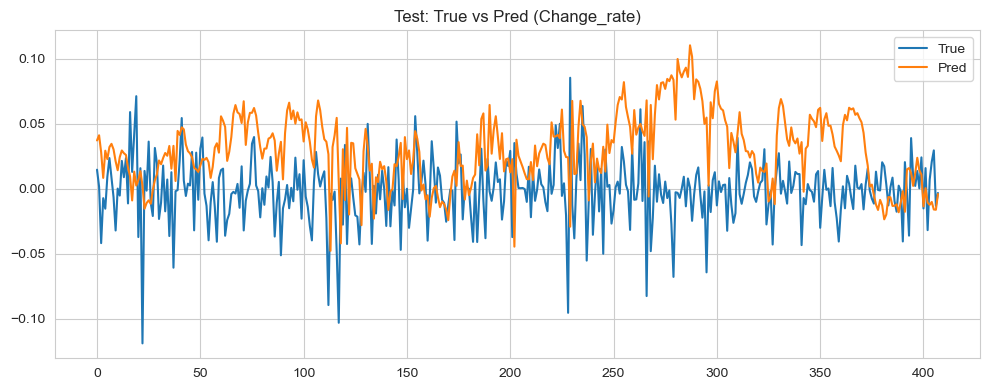

In [30]:
# 7) 예측 → 역스케일 → 실제 단위 성능 측정
# y_pred_s = model.predict(X_test, verbose=0).ravel()
# (N,)->(N,1)로 바꾼 뒤 역변환
# y_pred = y_scaler.inverse_transform(y_pred_s.reshape(-1,1)).ravel()
# y_true = y_scaler.inverse_transform(y_test.reshape(-1,1)).ravel()

y_pred = model.predict(X_test, verbose=0).ravel()
y_true = y_test

from sklearn.metrics import mean_absolute_error, mean_squared_error
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
print(f"Test MAE: {mse:.6f}, RMSE: {rmse:.6f}")

# 8) 간단 시각화 (실측 vs 예측)
import matplotlib.pyplot as plt
plt.figure(figsize=(10,4))
plt.plot(y_true, label='True')
plt.plot(y_pred, label='Pred')
plt.legend(); plt.title('Test: True vs Pred (Change_rate)'); plt.tight_layout()
plt.show()

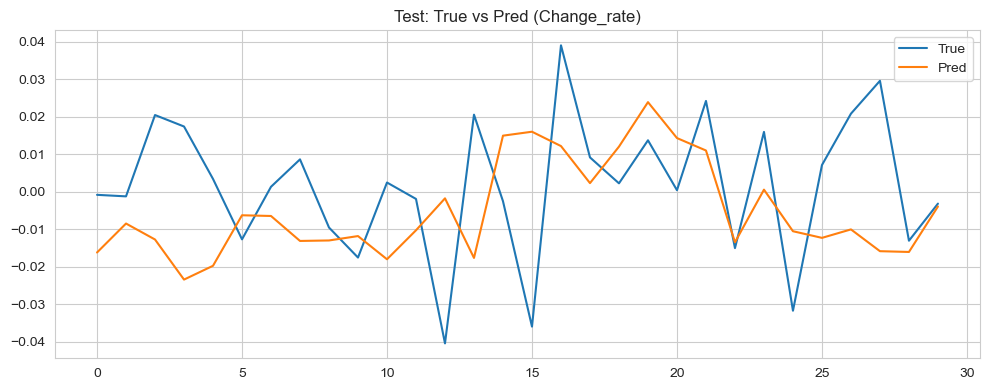

In [31]:
plt.figure(figsize=(10,4))
plt.plot(y_true[-30:], label='True')
plt.plot(y_pred[-30:], label='Pred')
plt.legend(); plt.title('Test: True vs Pred (Change_rate)'); plt.tight_layout()
plt.show()

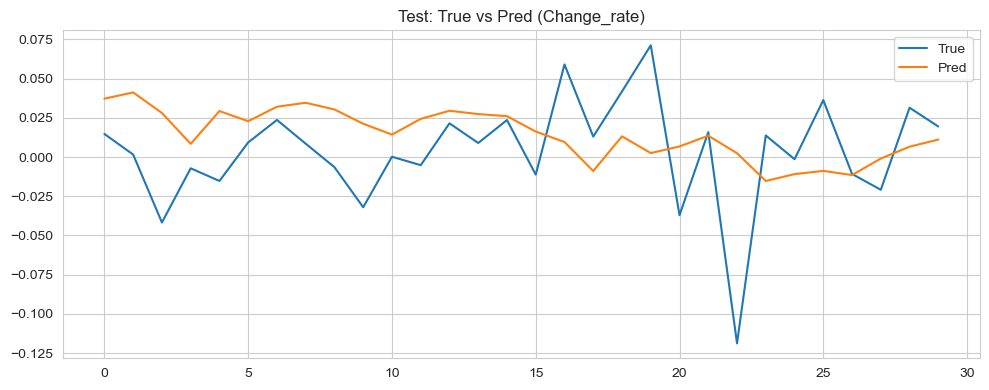

In [32]:
plt.figure(figsize=(10,4))
plt.plot(y_true[:30], label='True')
plt.plot(y_pred[:30], label='Pred')
plt.legend(); plt.title('Test: True vs Pred (Change_rate)'); plt.tight_layout()
plt.show()